# MLB Pitchers and Home State Climate Impact

In colder climate states, a decent number of baseball games can be played in cold weather (sometimes even in light snow fall). I was curious to see if the arms of MLB-level pitchers could potentially have been impacted by pitching in the cold during developmental years (little league and high school) once they reached the highest level. Reaching this level as a pitcher also requires some of them to throw a large number of innings after in college.

The following data was pulled using an SQL query from the Sean Lahman baseball database. The data obtained for the analysis below is from the years 2010 through 2019. I am using this time frame to show data that is recent to reflect current trends in nutrition, performance training and medical information related to pitching and the arm. *Please note that the 2020 season is not in this analysis due to not being included in the database used. It may be beneficial not to include the 2020 season due to its unusual nature and limited number of games (COVID-19).*

To qualify, each player had to have pitched at least 5 innings during that time span. By doing this, we are able to remove position players that may have had to pitch an inning occasionally for their team during a blowout loss, which is recorded in the Sean Lahman baseball database. The players who exceeded this innings limit then had their numbers compiled as an individual during the mentioned time frame.

Please note that the players in this analysis are all born in the United States. This allows us to analyze players born in the same country, with similar game rules, training schedules and league structures, but from varying climates.

In [1]:
#importing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read file

data = pd.read_csv('C:/Users/Ryan/Desktop/Baseball Analysis Projects/USA MLB Pitcher Stats 2010 to 2019.csv')

#verifying file read

data.head()

,Name,State_Born,Batting_Avg,Innings_Pitched,Games,Starts,Strikeouts,Earned_Runs,Walks_Allowed,Hit_Batters,Int_Walks,Hits,Homeruns_Allowed
0,A. J. Achter,OH,0.277,61,45,0,33,27,21,1,2,69,13
1,A. J. Burnett,AR,0.259,1146,187,186,1040,534,435,73,12,1127,116
2,A. J. Cole,FL,0.293,173,79,19,181,94,72,5,3,188,35
3,A. J. Griffin,CA,0.243,478,88,85,403,231,147,18,3,437,94
4,A. J. Minter,TX,0.255,105,117,0,130,50,47,3,6,106,7


In [3]:
#creating ERA column

data['ERA'] = round(((data['Earned_Runs'] / data['Innings_Pitched'])*9),2).astype(float)

#removing any infinite value ERAs

data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [4]:
data.head(5)

,Name,State_Born,Batting_Avg,Innings_Pitched,Games,Starts,Strikeouts,Earned_Runs,Walks_Allowed,Hit_Batters,Int_Walks,Hits,Homeruns_Allowed,ERA
0,A. J. Achter,OH,0.277,61,45,0,33,27,21,1,2,69,13,3.98
1,A. J. Burnett,AR,0.259,1146,187,186,1040,534,435,73,12,1127,116,4.19
2,A. J. Cole,FL,0.293,173,79,19,181,94,72,5,3,188,35,4.89
3,A. J. Griffin,CA,0.243,478,88,85,403,231,147,18,3,437,94,4.35
4,A. J. Minter,TX,0.255,105,117,0,130,50,47,3,6,106,7,4.29


In [5]:
#cleaning data dataframe to include only necessary columns for analysis

data = data[['Name', 'State_Born', 'Innings_Pitched', 'Games', 'Starts', 'ERA', 'Batting_Avg']]

data.head() #verifying column selection

,Name,State_Born,Innings_Pitched,Games,Starts,ERA,Batting_Avg
0,A. J. Achter,OH,61,45,0,3.98,0.277
1,A. J. Burnett,AR,1146,187,186,4.19,0.259
2,A. J. Cole,FL,173,79,19,4.89,0.293
3,A. J. Griffin,CA,478,88,85,4.35,0.243
4,A. J. Minter,TX,105,117,0,4.29,0.255


## Scraping Weather Data for Climate

In order to determine climate numbers, we must first obtain temperatures. To do this, we will scrape average state temperature weather data from the site usa.com, and then store the scraped data in a DataFrame.

In [6]:
#scraping weather data from usa.com

from bs4 import BeautifulSoup as BS
import requests

URL = 'http://www.usa.com/rank/us--average-temperature--state-rank.htm'

weather = requests.get(URL)
parser = BS(weather.content, 'html.parser')
body = parser.body
table = body.find_all('table')
df = pd.read_html(str(table))[0]

df.head() #verifying web scrape

,0,1,2
0,Rank,Average Temperature ▼,State / Population
1,1.,72.95°F,"Hawaii / 1,392,704"
2,2.,71.80°F,"Florida / 19,361,792"
3,3.,66.74°F,"Louisiana / 4,601,049"
4,4.,65.97°F,"Arizona / 6,561,516"


### Cleaning Scraped Climate Data

Now that we have our weather data stored into a DataFrame, we need to clean this data to make it easier to read as well as easier to use. We will rename the columns, remove the population numbers and the Fahrenheit symbol, and replace the full state names with abbreviations to help us match each state with the home states in our player database.

In [7]:
#cleaning scraped df

df.columns = ['Rank', 'Average_Temperature', 'State']

df = df[['State', 'Average_Temperature']] #removes rank column
df = df[1:]

In [8]:
#more cleaning

df['State'] = df['State'].astype(str).str.split('/').str[0]
df['State'] = df['State'].str.strip()

df['Average_Temperature'] = df['Average_Temperature'].astype(str).str.strip().str[:-2]
df['Average_Temperature'] = df['Average_Temperature'].astype(float)

In [9]:
#rename states to abbreviations

df['State'] = df['State'].replace({
    'Hawaii':'HI', 'Florida':'FL', 'Louisiana':'LA', 'Arizona':'AZ', 'Texas':'TX', 'Mississippi':'MS',
    'Alabama':'AL', 'Georgia':'GA', 'South Carolina':'SC', 'California':'CA', 'Oklahoma':'OK',
    'Arkansas':'AR', 'North Carolina':'NC', 'Tennessee':'TN', 'Nevada':'NV', 'Kentucky':'KY',
    'Virginia':'VA', 'District of Columbia':'DC', 'Missouri':'MO', 'Kansas':'KS', 'Maryland':'MD',
    'Delaware':'DE', 'West Virginia':'WV', 'New Mexico':'NM', 'New Jersey':'NJ', 'Indiana':'IN', 'Illinois':'IL',
    'Oregon':'OR', 'Ohio':'OH', 'Washington':'WA', 'Nebraska':'NE', 'Pennsylvania':'PA', 'Utah':'UT',
    'Rhode Island':'RI', 'Connecticut':'CT', 'New York':'NY', 'Massachusetts':'MA', 'Iowa':'IA', 'Michigan':'MI',
    'Idaho':'ID', 'Colorado':'CO', 'South Dakota':'SD', 'Wisconsin':'WI', 'New Hampshire':'NH', 'Montana':'MT',
    'Vermont':'VT', 'Wyoming':'WY', 'Maine':'ME', 'Minnesota':'MN', 'North Dakota':'ND', 'Alaska':'AK'
})

In [10]:
df.head(20) #showing top 20 climates

,State,Average_Temperature
1,HI,72.95
2,FL,71.80
3,LA,66.74
4,AZ,65.97
5,TX,65.97
6,MS,63.50
7,AL,62.68
8,GA,62.30
9,SC,61.70
10,CA,61.17


## Determining Warm and Cold Climate Threshold

With our weather data cleaned, we now need to determine what temperature to use as our "climate threshold." Remember, the numbers provided in the weather database are the average temperatures for each state for all four seasons combined.

For this analysis, our temperature threshold will be set as 55 degrees Fahrenheit. Based on the table shown above, this makes our last "warm climate" state as Virginia, and the first "cold weather state" as the Washington, DC area, which sounds about right.

In [11]:
#create climate column

df['Climate'] = ""

df['Climate'] = np.where(df.Average_Temperature >= 55, 'Warm', 'Cold')

In [12]:
#showing count of states in each climate

df['Climate'].value_counts()

Cold    34
Warm    17
Name: Climate, dtype: int64

As a note, our climate threshold has named 17 states as "warm climate" states and 34 states as "cold climate" states (this includes the Washington, DC area), as can be seen above.

For the next part of our analysis, we will now group each state by climate, put them into warm and cold groups, and then append our player DataFrame by adding a climate column based on if the state they were born in is a warm or cold climate state.

In [13]:
#create groups by climate

df = df.set_index('State')
climate = df.groupby('Climate')

warm = climate.get_group('Warm')
cold = climate.get_group('Cold')

In [14]:
#create climate column in data and fill column conditionally

data['Climate'] = data.State_Born.apply(lambda x: 'Warm' if x in warm.index else 'Cold')

#group by climate

climate_group = data.groupby('Climate')

In [15]:
data #shows first 5 and last 5 of DataFrame to verify climate column accuracy

,Name,State_Born,Innings_Pitched,Games,Starts,ERA,Batting_Avg,Climate
0,A. J. Achter,OH,61,45,0,3.98,0.277,Cold
1,A. J. Burnett,AR,1146,187,186,4.19,0.259,Warm
2,A. J. Cole,FL,173,79,19,4.89,0.293,Warm
3,A. J. Griffin,CA,478,88,85,4.35,0.243,Warm
4,A. J. Minter,TX,105,117,0,4.29,0.255,Warm
...,...,...,...,...,...,...,...,...
1347,Zack Britton,CA,600,397,46,3.09,0.228,Warm
1348,Zack Godley,SC,535,128,81,4.69,0.253,Warm
1349,Zack Greinke,FL,1979,311,311,3.19,0.238,Warm
1350,Zack Littell,NC,57,37,2,3.95,0.274,Warm


## Data Visualization

For this next section, we will now create visualizations for the analysis done so far.

To start, we will gather the number of pitchers in each of the warm and cold weather groups, then create a bar chart showing the results.

### Total Number of Pitchers by Climate

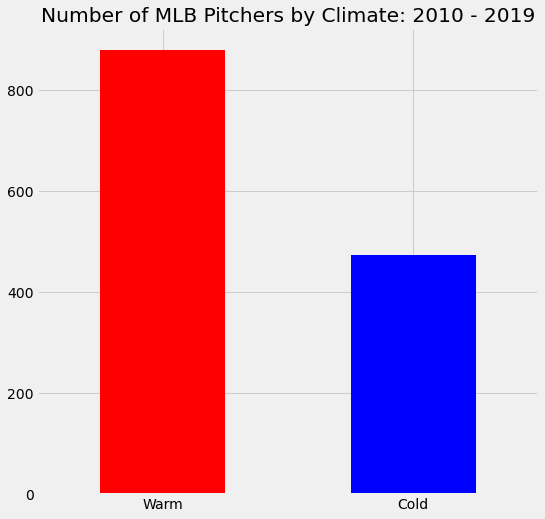

In [24]:
#find total number of pitchers by climate

pitcher_count = data['Climate'].value_counts()

#plot results

pitcher_count.plot.bar(title = 'Number of MLB Pitchers by Climate: 2010 - 2019', rot=0, figsize = (8, 8), 
                       color = ['red', 'blue'])
plt.style.use('fivethirtyeight')
plt.show()

In [17]:
#providing actual numbers to use with above graph

print('Number of MLB Pitchers by Climate: 2010-2019')
print(pitcher_count)

Number of MLB Pitchers by Climate: 2010-2019
Warm    879
Cold    473
Name: Climate, dtype: int64


The number of pitchers from 2010 to 2019 from warm weather states outnumbered those from cold weather states by a little over 400. That's a significant difference and is certainly noteworthy. The difference could mean that warm weather pitchers are more likely to make it through the minor leagues, as well as the collegiate level, to the majors with a lower chance of a significant arm injury.

### Innings Pitched by Climate

Next, we will analyze the number of innings pitched between the average pitcher from warm weather states against their cold climate counterparts.

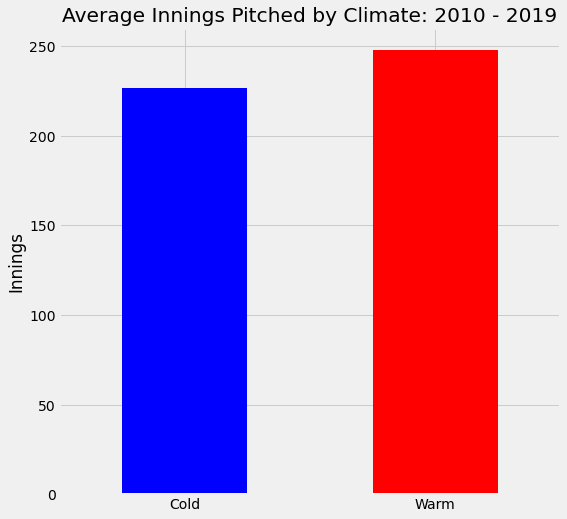

In [18]:
#find average innings pitched by climate

innings = climate_group['Innings_Pitched'].mean()

#plot results

innings.plot.bar(title = 'Average Innings Pitched by Climate: 2010 - 2019', rot=0, figsize = (8,8),
                color = ['blue', 'red'])
plt.style.use('fivethirtyeight')
plt.xlabel('')
plt.ylabel('Innings')
plt.show()

In [19]:
#providing actual values for reference

print('MLB Average Innings Pitched by Climate: 2010-2019')
print(innings)

MLB Average Innings Pitched by Climate: 2010-2019
Climate
Cold    226.839323
Warm    247.789534
Name: Innings_Pitched, dtype: float64


Interesting. The disparity between the groups in the chart above is notably smaller this time, with the warm group's average pitcher tossing around 20 more innings.

What can we take from this? It appears that once a pitcher makes it to the majors, the state (and climate) they are from does not seem to affect their workload as much. They have demonstrated a durability with their arms to navigate all the way through the minor leagues (and for some the college level plus minor leagues) to reach the majors.

### Appearances by Climate

Now we will analyze the number of games the average pitcher from each group appears in, and chart it below.

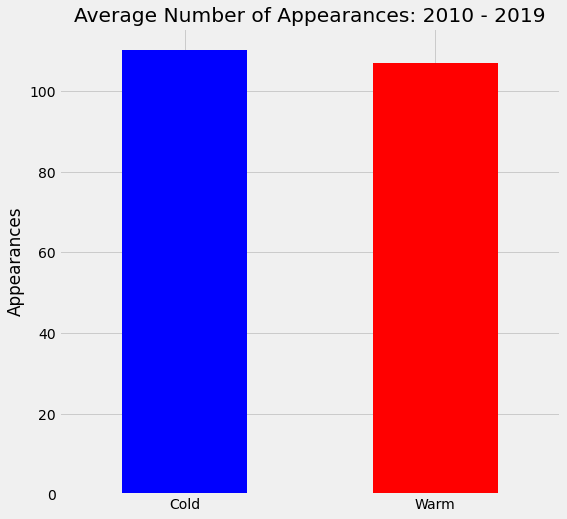

In [20]:
#find average games by climate

games = climate_group['Games'].mean()

#plot results

games.plot.bar(title = 'Average Number of Appearances: 2010 - 2019', rot=0, figsize=(8,8), color = ['blue', 'red'])
plt.style.use('fivethirtyeight')
plt.xlabel('')
plt.ylabel('Appearances')
plt.show()

In [21]:
#providing values for reference

print('Average Appearances by Climate')
print(round(games))

Average Appearances by Climate
Climate
Cold    110.0
Warm    107.0
Name: Games, dtype: float64


This time, the cold climate group takes the advantage, averaging 3 more appearances from its pitchers than its warm weather counterparts. This result once again can show if a pitcher avoids a significant arm injury long enough to reach the majors, the state they are born in does not have a large impact on their MLB workload.

### Starts by Climate

To round off our analysis, we will analyze the number of starts made by the average hurler in each group and chart it below.

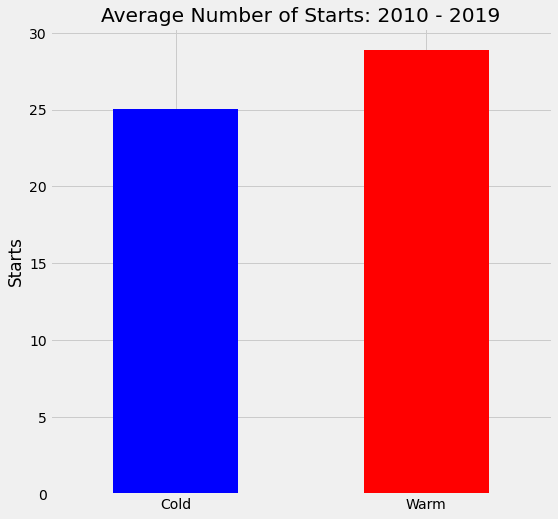

In [22]:
#find average starts by climate

starts = climate_group['Starts'].mean()

#plot results

starts.plot.bar(title = 'Average Number of Starts: 2010 - 2019', rot=0, figsize=(8,8), color = ['blue', 'red'])
plt.style.use('fivethirtyeight')
plt.xlabel('')
plt.ylabel('Starts')
plt.show()

In [23]:
#providing numbers for reference

print('Average Starts Made by Climate')
print(starts)

Average Starts Made by Climate
Climate
Cold    25.021142
Warm    28.869170
Name: Starts, dtype: float64


The warm climate group outpaces its counterpart by a little less than 4 starts. Given the huge disparity between the groups in the number of MLB pitchers in the time frame, a difference of about 4 starts on average isn't all that much.

## Conclusion

The warm climate pitcher group significantly outperforms its cold weather counterparts only in number during the analyzed time frame. The statistics outside of this are relatively even between the two groups in our other categories.

What does this mean? It can mean that if pitchers from cold climate states are going to have any significant arm injuries, it is much more likely in the college or minor league ranks than the major leagues. This is evidenced by the large disparity between the groups in their total player counts.

Once a pitcher reaches the major leagues, the innings pitched, starts and appearances made all begin to balance out. Pitchers begin to benefit from excellent offseason training and nutrition programs as well as in-season medical attention and nutrition, making home state climate during their younger years less impactful once they reach the highest level.